In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [15]:
# Load the processed data
df = pd.read_csv("../data/cleaned.csv")

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85296 entries, 0 to 85295
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   warranty                     85296 non-null  int64  
 1   variations                   85296 non-null  int64  
 2   tags                         85296 non-null  int64  
 3   accepts_mercadopago          85296 non-null  int64  
 4   automatic_relist             85296 non-null  int64  
 5   status                       85296 non-null  int64  
 6   seller_address_longitude     85296 non-null  float64
 7   seller_address_latitude      85296 non-null  float64
 8   shipping_local_pick_up       85296 non-null  int64  
 9   shipping_free_shipping       85296 non-null  int64  
 10  base_price_log               85296 non-null  float64
 11  price_log                    85296 non-null  float64
 12  initial_quantity_log         85296 non-null  float64
 13  sold_quantity_lo

In [18]:
boolean_cols = ['warranty', 'variations', 'tags', 'accepts_mercadopago',
                'automatic_relist', 'status', 'shipping_local_pick_up',
                'shipping_free_shipping', 'condition_used', 'buying_mode_buy_it_now',
                'buying_mode_classified', 'shipping_mode_me1', 
                'shipping_mode_me2', 'shipping_mode_not_specified',
                'sub_status_0_deleted', 'sub_status_0_expired',
                'sub_status_0_suspended']

# Convertir a entero
df[boolean_cols] = df[boolean_cols].astype(int)

In [21]:
X = df.drop('condition_used', axis=1)  # Features
y = df['condition_used'] #Target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Todas las columnas son numéricas, así que seleccionamos todas las columnas
num_cols = X.columns.tolist()

# Definir el preprocesador solo con la estandarización para las variables numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)  # Estandarizar las columnas numéricas
    ]
)


In [24]:
# Diccionario con diferentes clasificadores
model_dict = {
    'LogisticReg': LogisticRegression(max_iter=1000),
    'RandForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'GradBoost': GradientBoostingClassifier(),
    'NaiveBayes': GaussianNB(),
    'XGBoost': XGBClassifier()
}

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import joblib

def assess_classifiers(X_tr, y_tr, X_te, y_te, classifiers):
    performance = {}  # Diccionario para almacenar resultados
    top_model_name = None
    highest_accuracy = 0
    optimal_pipeline = None

    # Iterar sobre el diccionario de clasificadores
    for clf_name, clf in classifiers.items():
        # Crear el pipeline con el preprocesador y el clasificador
        processing_pipeline = Pipeline(steps=[
            ('data_transform', preprocessor),
            ('model', clf)
        ])
        
        # Entrenar el pipeline con los datos de entrenamiento
        processing_pipeline.fit(X_tr, y_tr)
        
        # Predecir las etiquetas para los datos de prueba
        y_predicted = processing_pipeline.predict(X_te)
        
        # Calcular la precisión
        acc = accuracy_score(y_te, y_predicted)
        performance[clf_name] = acc
        
        # Imprimir resultados
        print(f"{clf_name} - Accuracy: {acc:.2f}")
        print(classification_report(y_te, y_predicted))
        
        # Identificar el mejor modelo
        if acc > highest_accuracy:
            highest_accuracy = acc
            top_model_name = clf_name
            optimal_pipeline = processing_pipeline

    # Guardar el mejor modelo
    if optimal_pipeline is not None:
        joblib.dump(optimal_pipeline, f'../model/top_model_{top_model_name}.pkl')
        print(f"Top model saved as: ../model/top_model_{top_model_name}.pkl")

    return performance


In [26]:
model_results = assess_classifiers(X_train, y_train, X_test, y_test, model_dict)
model_results

LogisticReg - Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.86      0.69      0.76     14913
           1       0.66      0.84      0.74     10676

    accuracy                           0.75     25589
   macro avg       0.76      0.77      0.75     25589
weighted avg       0.78      0.75      0.75     25589

RandForest - Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.82      0.79      0.80     14913
           1       0.72      0.76      0.74     10676

    accuracy                           0.78     25589
   macro avg       0.77      0.77      0.77     25589
weighted avg       0.78      0.78      0.78     25589

DecisionTree - Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     14913
           1       0.68      0.68      0.68     10676

    accuracy                           0.73     25589
   macro avg       0.73      0.73      0.

{'LogisticReg': 0.752745320254797,
 'RandForest': 0.7750986752120052,
 'DecisionTree': 0.7347688459885107,
 'KNN': 0.7511821485794677,
 'GradBoost': 0.7685333541756223,
 'NaiveBayes': 0.658720543983743,
 'XGBoost': 0.7997186290984407}

In [27]:
model_file_path = f'../model/top_model_XGBoost.pkl'
loaded_pipeline = joblib.load(model_file_path)


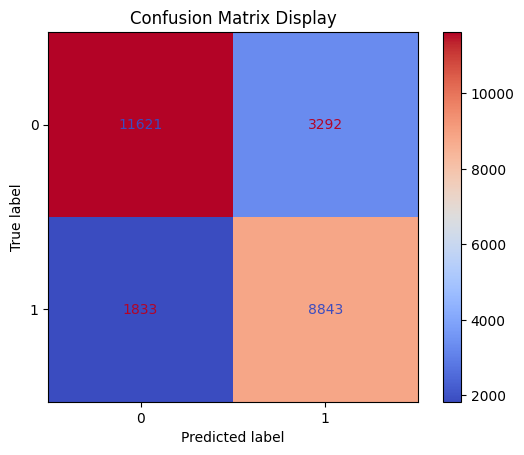

In [29]:
# Generar predicciones utilizando el pipeline cargado
y_predictions = loaded_pipeline.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_predictions)

# Mostrar la matriz de confusión con etiquetas
matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=loaded_pipeline.classes_)
matrix_display.plot(cmap='coolwarm')

# Título y visualización del gráfico
plt.title('Confusion Matrix Display')
plt.show()


La matriz de confusión es una herramienta útil para evaluar el rendimiento de un clasificador, ya que muestra las predicciones correctas e incorrectas en cada clase.

### Elementos importantes de la matriz:

- **Eje X (Predicted label)**: Etiquetas predichas por el modelo.
- **Eje Y (True label)**: Etiquetas verdaderas (reales) de los datos.

### Interpretación de los valores:

1. **True Negatives (TN)** (parte superior izquierda - valor: **11621**):
   - Estas son las observaciones en las que la clase real es "0" y el modelo también predijo "0".
   - En este caso, el modelo predijo correctamente **11621** veces que la clase era "0".

2. **False Positives (FP)** (parte superior derecha - valor: **3292**):
   - Estas son las observaciones en las que la clase real es "0" pero el modelo predijo "1".
   - El modelo cometió **3292** errores al predecir "1" cuando la clase real era "0" (también conocido como **error de tipo I**).

3. **False Negatives (FN)** (parte inferior izquierda - valor: **1833**):
   - Estas son las observaciones en las que la clase real es "1" pero el modelo predijo "0".
   - El modelo cometió **1833** errores al predecir "0" cuando la clase real era "1" (también conocido como **error de tipo II**).

4. **True Positives (TP)** (parte inferior derecha - valor: **8843**):
   - Estas son las observaciones en las que la clase real es "1" y el modelo también predijo "1".
   - El modelo predijo correctamente **8843** veces que la clase era "1".

